In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import numpy as np
import seaborn as sns

#### Table

In [3]:
url = "../Data/Annual_population_eurostat(mandatory).csv"
table = pd.read_csv(url)
display(table.head())
year_offset = 4

,Country,ISO3,citizen,sex,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Austria,AUT,EU28_FOR,F,288028.0,310759.0,329981.0,348012.0,365125.0,383295.0,NaN,NaN,NaN,NaN
1,Belgium,BEL,EU28_FOR,F,416232.0,428008.0,434889.0,440355.0,448655.0,457258.0,NaN,NaN,NaN,NaN
2,Switzerland,CHE,EU28_FOR,F,594052.0,610566.0,622893.0,630371.0,637330.0,645916.0,NaN,NaN,NaN,NaN
3,Cyprus,CYP,EU28_FOR,F,55730.0,57716.0,57673.0,59787.0,63044.0,62935.0,NaN,NaN,NaN,NaN
4,Czechia,CZE,EU28_FOR,F,72465.0,76736.0,81670.0,86132.0,91296.0,96186.0,NaN,NaN,NaN,NaN


### Percentage of foreign born in country

In [4]:
def percent_natural_born(country):
    pop_new = []
    country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
    country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")

    try:
        for i in range(10):
            pop_new.append(country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100)

        dataframe = pd.DataFrame({'year': range(2015,2025,1),
                           'percentage': pop_new})

        figure, axes = plt.subplots()
        axes.plot(dataframe['year'], dataframe['percentage'])

        axes.set_xlabel('Year')
        axes.set_ylabel('Percentage')
        
        

        y_min = 70
        step = 5
        
        if min(dataframe["percentage"]<y_min):
            y_min = 50

        axes.set_ylim(y_min)
        axes.set_yticks(range(y_min,100+step,step))

        axes.set_title('Percentage of natural born citizens in '+country)
        
        #Saving figure
        dir_name = "../Images/Countries/"+country
        try:
            os.makedirs(dir_name)
            # print(f"Directory '{dir_name}' created successfully!")
        except FileExistsError:
            pass
            # print(f"Directory '{dir_name}' already exists.")
        except Exception as e:
            pass
            # print(f"Error creating directory: {e}")
        
        figure.savefig(dir_name+"/natural_percent_"+country.lower()+".png")
        plt.close(figure)
        pass
    except:
            print(country)

# display(table.query("Country == 'Germany' and sex=='T'"))
# percent_natural_born("Germany")

# for country in table.Country.unique():
    # percent_natural_born(country)

# percent_natural_born("Liechtenstein")
# percent_natural_born("Luxembourg")


#### Debug

,Year,Natural_Percentage
0,2015,54.050036
1,2016,53.288422
2,2017,52.342521
3,2018,52.120996
4,2019,52.522097
5,2020,52.649543
6,2021,52.826241
7,2022,52.871333
8,2023,52.572226
9,2024,52.730005


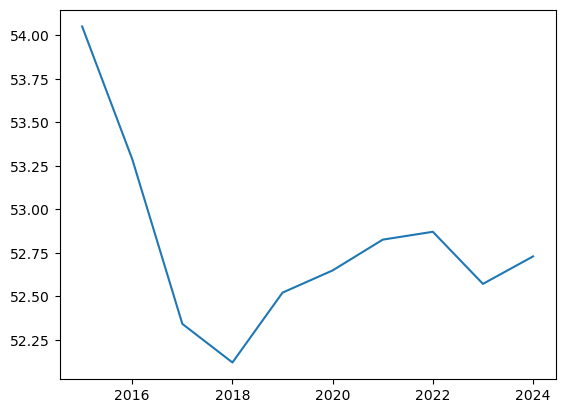

In [5]:
# display(table.query("Country == 'Luxembourg'"))
country_main = (table.query("Country =='Luxembourg' and sex=='T' and citizen == 'TOTAL'"))
country_natural = (table.query("Country =='Luxembourg' and sex=='T' and citizen == 'NAT'"))

pop_new = []

for i in range(10):
    pop_new.append(country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100)

df = pd.DataFrame({
    'Year': range(2015,2025,1),
    'Natural_Percentage': pop_new
})

display(df)

fig2, axes2 = plt.subplots()
axes2.plot(df['Year'], df['Natural_Percentage'])
pass




### Geography for foreign born in 2024

In [6]:
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px

#### Getting ratios of foreign born residents over the years
- Result is rounded to 2 decimal places


Documentation:
- get_ratio_dataframe expects one argument: *citizenship_type*. if left **None**, it will calculate all foreigners.
- citizenship_type can be in
    - **EU28_FOR**: EU28 countries (2013-2020) except reporting country
    - **NEU28_FOR**: Non-EU28 countries (2013-2020) nor reporting country
    - **NAT**: Reporting country
    - **STLS**: Stateless
    - **TOTAL**: Total
    - **UNK**: Unknown

In [7]:
def get_foreign_ratios(country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((100-((country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i])*100)).round(2))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        print("Error processing country: ",country)
        return None
    
def get_ratio_dataframe(citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_foreign_ratios(country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


### Setting up draw function
#### Documentation
- draw_choropleth accepts 4 arguments:
    - data: data
    - column: color of countries
    - range = **None**: range of color, set to auto by default
    - save_name = **None**: name of destination file, not exporting by default

In [35]:
def draw_choropleth(data, column,range=None,save_name=None,title=""):
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant"
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20) })
  fig.show()

  #I used Deepseek AI to write this code
  if save_name:
    try:
      fig.write_image(f"../Images/Maps/{save_name}.png", scale=4)
      print(f"Successfully saved to {save_name}.png")
    except Exception as e:
      print(f"Could not save PNG: {str(e)}")
      print("Install kaleido with: pip install -U kaleido")
  

### Getting countries and drawing graph
- color range is set to max 25

In [58]:
#Getting countries

# display_countries = get_ratio_dataframe("EU28_FOR")
# year = 2020
# title="Percentage of citizens born in other EU countries in "+str(year)
# draw_choropleth(display_countries, str(year),(0,30),"EU_born_percentage_"+str(year),title)

# display_countries = get_ratio_dataframe("UNK")
# year = 2024
# title="Percentage of unknown residents in "+str(year)
# draw_choropleth(display_countries, str(year),(0,0.3),"unknown_percentage_"+str(year),title)

# display_countries = get_ratio_dataframe("NEU28_FOR")
# year = 2020
# title="Percentage of citizens born in other non-EU countries in "+str(year)
# draw_choropleth(display_countries, str(year),(0,15),"non-EU_born_percentage_"+str(year),title)

# display_countries = get_ratio_dataframe("STLS")
# year = 2024
# title="Percentage of stateless residents in "+str(year)
# draw_choropleth(display_countries, str(year),(0,0.2),"stateless_percentage_"+str(year),title)

display_countries = get_ratio_dataframe()
year = 2024
title="Percentage of non citizens in "+str(year)
draw_choropleth(display_countries, str(year),(0,30),"non-citizens_"+str(year),title)




Error processing country:  Albania
Error processing country:  Armenia
Error processing country:  Georgia
Error processing country:  Moldova, Republic of
Error processing country:  Montenegro
Error processing country:  North Macedonia
Error processing country:  Serbia
Error processing country:  Ukraine


Successfully saved to non-citizens_2024.png
